In [1]:
test=1
test

1

In [2]:
from matplotlib import cm, colors, pyplot as plt
import metaworld
import torch
from torch import nn
import copy
import ray
import numpy as np
import seaborn as sns

from nupic.embodied.utils.garage_utils import create_policy_net
from nupic.embodied.multitask.samplers.gpu_sampler import SamplerEvalOnly
from nupic.embodied.multitask.hooks.sparse_viz import (
    AverageSegmentActivationsHook,
    HiddenActivationsPercentOnHook,
    CombinedSparseVizHook
)

from garage.experiment.task_sampler import MetaWorldTaskSampler

from nupic.embodied.utils.parser_utils import merge_args
sys.path.append("/Users/lsouza/nta/nupic.embodied/projects/multitask")
from args_parser import create_exp_parser
from experiments import CONFIGS
    
import numpy
import torch

from scipy.spatial.distance import cosine
from collections import Counter, defaultdict

objc[29826]: Class GLFWApplicationDelegate is implemented in both /Users/lsouza/.mujoco/mujoco200/bin/libglfw.3.dylib (0x12d23b778) and /Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/glfw/libglfw.3.dylib (0x12d2f4740). One of the two will be used. Which one is undefined.
objc[29826]: Class GLFWWindowDelegate is implemented in both /Users/lsouza/.mujoco/mujoco200/bin/libglfw.3.dylib (0x12d23b700) and /Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/glfw/libglfw.3.dylib (0x12d2f4768). One of the two will be used. Which one is undefined.
objc[29826]: Class GLFWContentView is implemented in both /Users/lsouza/.mujoco/mujoco200/bin/libglfw.3.dylib (0x12d23b7a0) and /Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/glfw/libglfw.3.dylib (0x12d2f47b8). One of the two will be used. Which one is undefined.
objc[29826]: Class GLFWWindow is implemented in both /Users/lsouza/.mujoco/mujoco200/bin/libglfw.3.dylib (0x12d23b818) and /Users/lsou

# MLP-Dendrites Comparison

In [3]:
class HiddenActivationsPercentOnHookMLP(HiddenActivationsPercentOnHook):
    def attach(self, network):
        network.module.mean_log_std._layers[1].register_forward_hook(self.activation_hook_fn)     

def get_updated_policy(policy, hook):
    with torch.no_grad():
        updated_policy = copy.deepcopy(policy)
    updated_policy.eval()
    hook(updated_policy)
    return updated_policy

def init_experiment(state_path, config, mlp=False, average_hook=False):
    mt_env = metaworld.MT10(seed=41)
    train_task_sampler = MetaWorldTaskSampler(
        mt_env, "train", add_env_onehot=True
    )
    mt_train_envs = train_task_sampler.sample(10)
    env = mt_train_envs[0]()

    exp_parser = create_exp_parser()
    trainer_args = merge_args(exp_parser.parse_dict(CONFIGS[config]))

    env = mt_train_envs[0]()
    policy = create_policy_net(env_spec=env.spec, net_params=trainer_args)

    if state_path is not None:
        experiment_state = torch.load(state_path, map_location=torch.device('cpu'))
        policy.load_state_dict(experiment_state["algorithm"]["policy"])

    if mlp:
        print("Using MLP network")
        hook = HiddenActivationsPercentOnHookMLP
    elif average_hook:
        hook =AverageSegmentActivationsHook
    else:
        hook = HiddenActivationsPercentOnHook

    net = get_updated_policy(policy, hook)

    sampler = SamplerEvalOnly(
        agent=net,
        envs=mt_train_envs,
        max_episode_length=env.spec.max_episode_length,
        cpus_per_worker=0.5,
        gpus_per_worker=0,
        workers_per_env=1,
        seed=42,
    )

    return net, sampler

def collect_data(net, sampler, num_eval_eps=1):

    samples, hook_data = sampler.obtain_exact_episodes(
        n_eps_per_worker=num_eval_eps,
        agent_update=net,
        collect_hook_data=True,
    )

    data = next(iter(hook_data.values()))

    return samples, data

def get_distances(data):
    distances = np.zeros((10,10))
    for i in range(len(data)):
        for j in range(len(data)):
            average_acts_i = data[i].mean(dim=0)
            average_acts_j = data[j].mean(dim=0)
            distances[i][j] = cosine(average_acts_i, average_acts_j)

    return distances

def calculate_avg_distances(data, num_samples=40):
    distances_same_task = []
    distances_other_task = []
    for i in range(len(data)):
        for j in range(len(data)):
            if i == j:
                distances_per_type = distances_same_task
            else:
                distances_per_type = distances_other_task
            acts_i = data[i]
            acts_j = data[j]
            for x in range(num_samples):# range(acts_i.shape[0]):
                for y in range(num_samples): # range (acts_j.shape[0]):
                    distances_per_type.append(cosine(acts_i[x, :], acts_j[y, :]))
    print("\nDistance same task: {:.4f}, across tasks: {:.4f}\n".format(
        np.mean(distances_same_task), np.mean(distances_other_task)
    ))          

def report(state_path, config, mlp=False, num_samples=100, average_hook=False):
    net, sampler = init_experiment(state_path, config, mlp=mlp, average_hook=average_hook)
    data = collect_data(net, sampler)
    distances = get_distances(data)
    calculate_avg_distances(data, num_samples=num_samples)
    sns.heatmap(distances)
    return net, sampler, data, distances

def get_network(state_path, config, mlp=False, num_samples=100, average_hook=False):
    net, sampler = init_experiment(state_path, config, mlp=mlp, average_hook=average_hook)
    return net, sampler




## Comparisons


Distance same task: 0.4117, across tasks: 0.8861



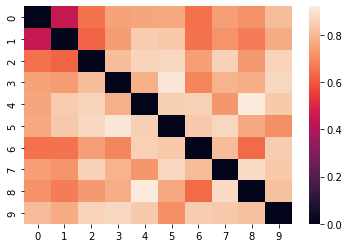

In [21]:
state_path = "/Users/lsouza/nta/results/no_preprocess3-wouv839/experiment_state.p"
config = "no_preprocess6"
report(state_path, config, mlp=False);

Using MLP network

Distance same task: 0.4253, across tasks: 0.8937



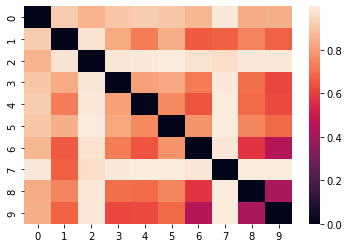

In [22]:
state_path_mlp = "/Users/lsouza/nta/results/mlp_final-dtbi450/experiment_state.p"
config_mlp = "mlp_final"
report(state_path_mlp, config_mlp, mlp=True);

Using MLP network

Distance same task: 0.0668, across tasks: 0.9314



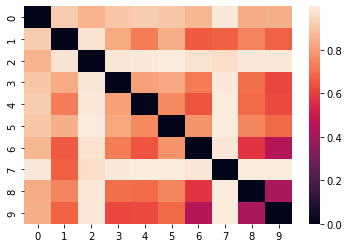

In [24]:
def report(state_path, config, mlp=False, num_samples=100, average_hook=False):
    net, sampler = init_experiment(state_path, config, mlp=mlp, average_hook=average_hook)
    data = collect_data(net, sampler)
    distances = get_distances(data)
    calculate_avg_distances(data, num_samples=num_samples)
    sns.heatmap(distances)
    return net, sampler, data, distances

net, sampler, data, distances = report(state_path_mlp, config_mlp, num_samples=10, mlp=True)

In [45]:
state_path = "/Users/lsouza/nta/results/no_preprocess3-wouv839/experiment_state.p"
config = "no_preprocess6"
net, sampler = init_experiment(state_path, config)
samples, data = collect_data(net, sampler, num_eval_eps=3)

/Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/garage/experiment/deterministic.py:36: UserWarning: Enabeling deterministic mode in PyTorch can have a performance impact when using GPU.
  warnings.warn(


In [46]:
for task_id in range(10):
    print(len(data[task_id]))

1500
1500
1500
1500
1500
1500
1500
1500
1500
1500


In [122]:
from collections import Counter, defaultdict
task_ids = {}
task_aggs = {}

# dictionary: task -> list of samples. 
for task_id in range(10):
    task_ids[task_id] = torch.zeros(data[0][0].shape)
    task_aggs[task_id] = torch.zeros(data[0][0].shape)
    num_samples = len(task_ids[task_id])
    for sample_tensor in data[task_id]:
        task_ids[task_id] += sample_tensor > 0
    
    # task_aggs[task_id] = task_ids[task_id] > num_samples * .50

    _, argmax_indices = torch.topk(task_ids[task_id], k=int(num_samples/4))
    task_aggs[task_id][argmax_indices] = 1    


In [124]:
task_aggs[0]

tensor([0., 0., 0.,  ..., 1., 0., 0.])

In [ ]:
# _, argmax_indices = torch.topk(task_ids[task_id])
# task_aggs[task_id][argmax_indices] = 1

In [125]:
for task_id in range(10):
    print(task_aggs[task_id].sum())

tensor(700.)
tensor(700.)
tensor(700.)
tensor(700.)
tensor(700.)
tensor(700.)
tensor(700.)
tensor(700.)
tensor(700.)
tensor(700.)


In [126]:
distances = np.zeros((10,10))
for taskA in range(10):
    for taskB in range(10):
        distances[taskA][taskB] = (task_aggs[taskA] * task_aggs[taskB]).sum()

<AxesSubplot:>

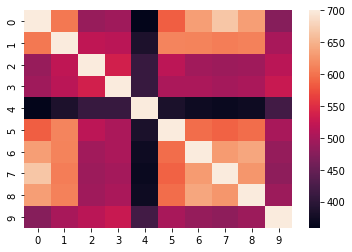

In [127]:
sns.heatmap(distances)

In [35]:
task_ids[0][0] += 1

In [36]:
task_ids

defaultdict(collections.Counter, {0: Counter({0: 1})})

# Aggregate overlap

In [105]:
tasks_ordered = []
for task in range(0,15000,1500):
    tasks_ordered.append(samples.env_infos["task_name"][task])
tasks_ordered

['reach-v2',
 'push-v2',
 'pick-place-v2',
 'door-open-v2',
 'drawer-open-v2',
 'drawer-close-v2',
 'button-press-topdown-v2',
 'peg-insert-side-v2',
 'window-open-v2',
 'window-close-v2']

In [129]:
from collections import Counter, defaultdict

def calculate_distance_overlap(task_aggs):
    distances = np.zeros((10,10))
    for taskA in range(10):
        for taskB in range(10):
            distances[taskA][taskB] = (task_aggs[taskA] * task_aggs[taskB]).sum()
    return distances

def aggregate_representations(data, agg_by_kwinner=True):
    task_ids = {}
    task_aggs = {}

    # dictionary: task -> list of samples. 
    for task_id in range(10):
        task_ids[task_id] = torch.zeros(data[0][0].shape)
        num_samples = len(task_ids[task_id])
        for sample_tensor in data[task_id]:
            task_ids[task_id] += sample_tensor > 0

        if agg_by_kwinner:
            task_aggs[task_id] = torch.zeros(data[0][0].shape)       
            _, argmax_indices = torch.topk(task_ids[task_id], k=int(num_samples/4))
            task_aggs[task_id][argmax_indices] = 1    
        else:
            task_aggs[task_id] = task_ids[task_id] > num_samples * .50

    return task_aggs




/Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/garage/experiment/deterministic.py:36: UserWarning: Enabeling deterministic mode in PyTorch can have a performance impact when using GPU.
  warnings.warn(


<AxesSubplot:>

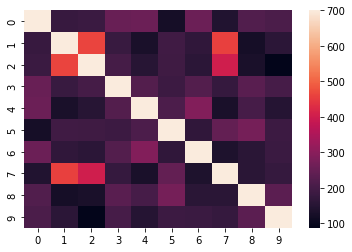

In [130]:
state_path = "/Users/lsouza/nta/results/no_preprocess3-wouv839/experiment_state.p"
config = "no_preprocess6"
net, sampler = init_experiment(state_path, config, mlp=False)
samples, data = collect_data(net, sampler, num_eval_eps=3)

task_aggs = aggregate_representations(data)
distances = calculate_distance_overlap(task_aggs)
sns.heatmap(distances)

In [5]:
state_path = "/Users/lsouza/nta/results/no_preprocess3-wouv839/experiment_state.p"
config = "no_preprocess6"
net, sampler = init_experiment(state_path, config, mlp=False)
samples, data = collect_data(net, sampler, num_eval_eps=3)

task_aggs = aggregate_representations(data)
distances = calculate_distance_overlap(task_aggs)
sns.heatmap(distances, vmin=0, vmax=700)

/Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/garage/experiment/deterministic.py:36: UserWarning: Enabeling deterministic mode in PyTorch can have a performance impact when using GPU.
  warnings.warn(
/Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


NameError: name 'aggregate_representations' is not defined

In [2]:
state_path = "/Users/lsouza/nta/results/mlp_final-dtbi450/experiment_state.p"
config = "mlp_final"
net, sampler = init_experiment(state_path, config, mlp=True)
samples, data = collect_data(net, sampler, num_eval_eps=3)

task_aggs = aggregate_representations(data)
distances = calculate_distance_overlap(task_aggs)
sns.heatmap(distances, vmin=0, vmax=700)

NameError: name 'init_experiment' is not defined

# Pairwise Overlap

In [164]:
import torch

L = 10
N = 20
A = torch.ones(L)
# A.expand(N, L) # specifies new size
A.repeat(N,1) # specifies number of copies

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [172]:
t = torch.Tensor(
    [[1,1,1],
    [2,2,2],
    [3,3,3]]
)
t.repeat(10, 1)

tensor([[1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.],
        [1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.],
        [1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.],
        [1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.],
        [1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.],
        [1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.],
        [1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.],
        [1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.],
        [1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.],
        [1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.]])

In [175]:
torch.cat([t[idx].repeat(10,1) for idx in range(t.shape[0])])

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.]])

In [14]:
t = torch.Tensor(
    [[1,1,1],
    [2,2,2],
    [3,3,3]]
)
torch.cat([t[idx].to(torch.int8).repeat(10,1) for idx in range(t.shape[0])])

tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]], dtype=torch.int8)

In [73]:

def calculate_pairwise_overlaps(data):

    num_tasks = len(data)
    num_samples, num_units_per_tensor = data[0].shape
    overlaps_count = torch.zeros(num_tasks, num_tasks)
    div_factor = num_units_per_tensor * num_samples ** 2

    expanded_data = {i: data[i].to(torch.bool).repeat(num_samples, 1) for i in range(num_tasks) }

    for taskA in range(num_tasks):
        for taskB in range(taskA, num_tasks):            
            # stack n samples in A
            expandedA = torch.cat([data[taskA][idx].to(torch.bool).repeat(num_samples,1) for idx in range(num_samples)])
            expandedB = expanded_data[taskB]

            overlaps_count[taskA, taskB] += ((expandedA * expandedB) > 0).sum()
            overlaps_count[taskB, taskA] = overlaps_count[taskA, taskB]

    return overlaps_count / div_factor

data = {
    0: torch.stack([torch.ones(100)*-1, torch.ones(100)]),
    1: torch.stack([torch.ones(100), torch.ones(100)]),
    2: torch.stack([torch.ones(100), torch.ones(100)]),
}
data[0][0][2] = 0
calculate_pairwise_overlaps(data)

tensor([[0.9925, 0.9950, 0.9950],
        [0.9950, 1.0000, 1.0000],
        [0.9950, 1.0000, 1.0000]])

In [186]:
expandedA.shape, expandedB.shape

(torch.Size([4, 100]), torch.Size([4, 100]))

In [183]:

# Test 1
data = {
    0: torch.stack([torch.ones(100)*-1, torch.ones(100)]),
    1: torch.stack([torch.ones(100), torch.ones(100)]),
    2: torch.stack([torch.ones(100), torch.ones(100)]),
}
# data[0][0][2] = 0

overlaps_count = calculate_pairwise_overlaps(data)
print(overlaps_count)  # should equal all 1.0

# # Test 2
# data = {
#     0: [torch.zeros(100), torch.zeros(100)],
#     1: [torch.zeros(100), torch.zeros(100)],
# }

# overlaps_count = calculate_pairwise_overlaps(data)
# print(overlaps_count)  # should equalall  0.0

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])


/Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/garage/experiment/deterministic.py:36: UserWarning: Enabeling deterministic mode in PyTorch can have a performance impact when using GPU.
  warnings.warn(


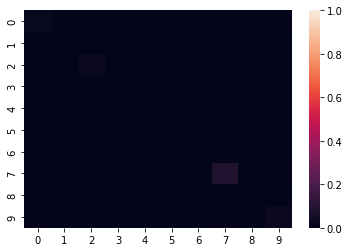

In [19]:
def dendrite_viz():
    net, sampler = init_experiment(
        state_path="/Users/lsouza/nta/results/no_preprocess3-wouv839/experiment_state.p", 
        config="no_preprocess6", 
        mlp=False
    )
    samples, data = collect_data(net, sampler, num_eval_eps=1)

    pairwise_overlap = calculate_pairwise_overlaps(data)
    sns.heatmap(pairwise_overlap, vmin=0, vmax=1)
    return data, pairwise_overlap

dendrite_data, dendrite_pairwise_overlap = dendrite_viz()

Using MLP network


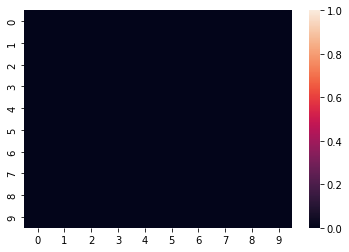

In [20]:
def mlp_viz():
    net, sampler = init_experiment(
        state_path="/Users/lsouza/nta/results/mlp_final-dtbi450/experiment_state.p", 
        config="mlp_final", 
        mlp=True
    )
    samples, data = collect_data(net, sampler, num_eval_eps=1)

    pairwise_overlap = calculate_pairwise_overlaps(data)
    sns.heatmap(pairwise_overlap, vmin=0, vmax=1)
    return data, pairwise_overlap

mlp_data, mlp_pairwise_overlap = mlp_viz()

<AxesSubplot:>

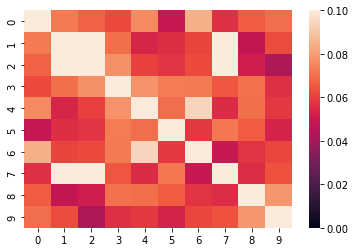

In [80]:
# dendrite_pairwise_overlap = calculate_pairwise_overlaps(dendrite_data)
sns.heatmap(dendrite_pairwise_overlap, vmin=0, vmax=.1)

<AxesSubplot:>

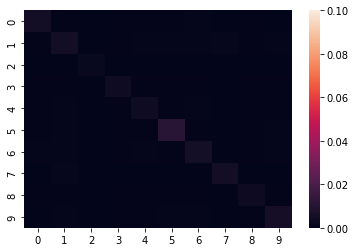

In [81]:
# mlp_pairwise_overlap = calculate_pairwise_overlaps(mlp_data)
sns.heatmap(mlp_pairwise_overlap, vmin=0, vmax=.1)

In [96]:
dendrite_data[5][200].bool().sum(), mlp_data[5][200].bool().sum()

(tensor(700), tensor(36))

In [106]:
mlp_data[5][50][100:200]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])

In [114]:
2800 - (mlp_data[0].sum(axis=0) == 0).sum()

tensor(41)

In [123]:
mlp_data[0].bool().sum(axis=0)[mlp_data[0].sum(axis=0) != 0].to(torch.int32)

tensor([  2, 129, 500,  10,   7,   3,  10,  14,   8,  41, 500, 500, 302,  19,
          7,  18, 158, 483, 482, 494, 461,  17, 500, 491, 157,   2,  34, 474,
        500,   9, 492,  10,   8,   6, 487,   8,  32, 181,  10, 461,  40],
       dtype=torch.int32)

In [113]:
2800 - (dendrite_data[0].sum(axis=0) == 0).sum()

tensor(2371)

In [115]:
acts = torch.cat([mlp_data[idx] for idx in range(10)])
acts.shape

torch.Size([5000, 2800])

In [117]:
2800 - (acts.sum(axis=0) == 0).sum()

tensor(760)

In [118]:
dendrite_acts = torch.cat([dendrite_data[idx] for idx in range(10)])
2800 - (dendrite_acts.sum(axis=0) == 0).sum()

tensor(2792)

In [27]:
div_factor = 2800 * 500 ** 2

In [59]:
t = torch.randn(10)
t, t.to(torch.int8), t.to(torch.int16), t.to(torch.int32)
# ((torch.abs(t) > 0) * (torch.abs(t) > 0)).sum()

tensor(10)

In [44]:
dendrite_pairwise_overlap[:5, :5].to(torch.int8)

tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int8)

In [39]:
mlp_pairwise_overlap[:5, :5].to(torch.int8)

tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int8)

In [55]:
num_samples = 40
data = mlp_data
num_tasks = len(data)
num_units_per_tensor = data[0][0].shape[0]
overlaps_count = torch.zeros(num_tasks, num_tasks)
div_factor = num_units_per_tensor * num_samples ** 2
div_factor

4480000

In [88]:
net, sampler = init_experiment(
    state_path="/Users/lsouza/nta/results/mlp_final-dtbi450/experiment_state.p", 
    config="mlp_final", 
    mlp=True
)


/Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
Using MLP network
/Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/garage/experiment/deterministic.py:36: UserWarning: Enabeling deterministic mode in PyTorch can have a performance impact when using GPU.
  warnings.warn(


In [89]:
net.module.mean_log_std._layers[1]

Sequential(
  (linear): Linear(in_features=2800, out_features=2800, bias=True)
  (non_linearity): <built-in method relu of type object at 0x141473c90>
)